In [1]:
# importing libraries
from os import getcwd, path
from pathlib import Path

from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from typing import Set, List

from data_analysis_helper_fun import *


In [2]:
from data_analysis_helper_fun import heat_maps_by_weights

## Loading data

In [3]:
 # relative path to data directory
data_dir = path.join(Path(getcwd()).parent.absolute(), "data")
data_set_name = 're_data_20231108_process_results'
data_file_name = f'{data_set_name}.csv.tar.gz'
re_data = load_re_data(data_dir, data_file_name)

In [4]:
print('\033[1m' + 'General information: ' + '\033[0m')
print("   Amount of rows:" , len(re_data))
print('   Number of dialectical structures:', len(re_data['ds'].unique()))
print('   Overall number of initial commitments:', len(re_data['init_coms'].unique()))
print('   Sentence-pools:' , re_data['n_sentence_pool'].unique())
print('   Models:' , re_data['model_name'].unique())
print('\n')

General information: 
   Amount of rows: 2047
   Number of dialectical structures: 8
   Overall number of initial commitments: 20
   Sentence-pools: [6 7]
   Models: ['StandardGlobalReflectiveEquilibrium'
 'StandardGlobalReflectiveEquilibriumLinearG'
 'StandardLocalReflectiveEquilibrium'
 'StandardLocalReflectiveEquilibriumLinearG']




In [5]:
re_data.columns

Index(['model_name', 'ds', 'tau_name', 'n_sentence_pool', 'ds_arg_size',
       'ds_infer_dens', 'ds_n_consistent_complete_positions', 'ds_mean_prem',
       'ds_variance_prem', 'tau_truths', 'principles', 'account_penalties',
       'faithfulness_penalties', 'weight_account', 'weight_systematicity',
       'weight_faithfulness', 'init_coms', 'init_coms_size',
       'init_coms_n_tau_truths', 'init_coms_n_tau_falsehoods',
       'init_coms_n_consistent_complete_positions', 'init_coms_dia_consistent',
       'init_coms_closed', 'fixed_point_coms', 'fixed_point_coms_size',
       'fixed_point_coms_n_tau_truths', 'fixed_point_coms_n_tau_falsehoods',
       'fixed_point_coms_closed', 'fixed_point_coms_consistent',
       'fixed_point_coms_n_consistent_complete_positions',
       'fixed_point_theory', 'fixed_point_theory_closure',
       'init_coms_min_ax_bases', 'n_init_coms_min_ax_base',
       'achievements_evolution', 'fixed_point_dia_consistent',
       'init_final_coms_simple_hamming'

## Setup dataframes

In [6]:
""" 
If `analyse_branches` is set to `true`, all branches of RE processes are considered for the analysis. 
This may lead to the multiple counting of a unique fixed point, 
if they are reached on different paths from a simulation setup.
Otherwise, the subsequent analysis comprises only unique fixed points per simulation setups
"""
analyse_branches = True

In [7]:
# the analysis of global optima is not affected by `analyse branches`

# restrict data to unique simulation setups to prevent multiple counting of branches 

re_data_unique_setups = re_data.drop_duplicates(["model_name",
                         "ds",
                         "n_sentence_pool",
                         'weight_account', 
                         'weight_systematicity',
                         'weight_faithfulness', 
                         'init_coms',
                         #'fixed_point_coms',
                         #'fixed_point_theory'
                        ])

# restrict to relevant columns
go_data = re_data_unique_setups[["model_name",
                                 "ds",
                                 "init_coms",
                                 "weight_account", 
                                 "weight_systematicity", 
                                 "init_coms_dia_consistent", 
                                 "go_coms_consistent"]]

# explode information about global optima, which is stored rowwise (per simulation setup) 
# in lists (e.g. in the column `go_coms_consistent`) 
exploded_go_data = go_data.set_index(["model_name",
                                      "ds",
                                      "init_coms",
                                      "weight_account", 
                                      "weight_systematicity", 
                                      "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()

exploded_go_data.shape

(2842, 7)

In [8]:
if analyse_branches:
    
    # use all rows and restrict to relevant columns
    fp_data = re_data[["model_name",
                       "ds",
                       "init_coms",
                       "weight_account", 
                       "weight_systematicity", 
                       "init_coms_dia_consistent", 
                       "fixed_point_coms_consistent"]]
    
    # rename fixed point columns 
    # Note: data is already exploded
    exploded_fp_data = fp_data.rename(columns={"fixed_point_coms_consistent": "fp_coms_consistent",})
    
    
else:
    
    # use unique setups and restrict to relevant columns
    fp_data = re_data_unique_setups[["model_name",
                                     "ds",
                                     "init_coms",
                                     "weight_account", 
                                     "weight_systematicity", 
                                     "init_coms_dia_consistent", 
                                     "fp_coms_consistent"]]
    
    # explode information about unique fixed points, which is stored rowwise (per simulation setup) 
    # in lists (e.g. in the column `go_coms_consistent`) 
    exploded_fp_data = fp_data.set_index(["model_name",
                                          "ds",
                                          "init_coms",
                                          "weight_account", 
                                          "weight_systematicity", 
                                          "init_coms_dia_consistent"]).apply(pd.Series.explode).reset_index()
    
exploded_fp_data.shape

(2047, 7)

In [9]:
# quick check: number of unique fixed points
re_data_unique_setups["n_fixed_points"].sum()

1663

## Calculating cases

In [10]:
# global optima
exploded_go_data['go_inconsistency_eliminating_case'] = exploded_go_data.apply(lambda row: (not row['init_coms_dia_consistent']) and row['go_coms_consistent'], axis = 1)
exploded_go_data['go_consistency_preserving_case'] = exploded_go_data.apply(lambda row: row['init_coms_dia_consistent'] and row['go_coms_consistent'], axis = 1)
exploded_go_data['go_inconsistency_preserving_case'] = exploded_go_data.apply(lambda row: (not row['init_coms_dia_consistent']) and (not row['go_coms_consistent']), axis = 1)
exploded_go_data['go_consistency_eliminating_case'] = exploded_go_data.apply(lambda row: row['init_coms_dia_consistent'] and (not row['go_coms_consistent']), axis = 1)

In [11]:
display(exploded_go_data.head(6)[[#'global_optima', 
                                  'go_coms_consistent', 
                                  'go_inconsistency_eliminating_case',
                                  'go_consistency_preserving_case',
                                  'go_inconsistency_preserving_case',
                                  'go_consistency_eliminating_case'
                                 ]])

,go_coms_consistent,go_inconsistency_eliminating_case,go_consistency_preserving_case,go_inconsistency_preserving_case,go_consistency_eliminating_case
0,False,False,False,True,False
1,False,False,False,True,False
2,True,False,True,False,False
3,True,False,True,False,False
4,False,False,False,True,False
5,False,False,False,True,False


In [12]:
# fixed points
exploded_fp_data['fp_inconsistency_eliminating_case'] = exploded_fp_data.apply(lambda row: (not row['init_coms_dia_consistent']) and row['fp_coms_consistent'], axis = 1)
exploded_fp_data['fp_consistency_preserving_case'] = exploded_fp_data.apply(lambda row: row['init_coms_dia_consistent'] and row['fp_coms_consistent'], axis = 1)
exploded_fp_data['fp_inconsistency_preserving_case'] = exploded_fp_data.apply(lambda row: (not row['init_coms_dia_consistent']) and (not row['fp_coms_consistent']), axis = 1)
exploded_fp_data['fp_consistency_eliminating_case'] = exploded_fp_data.apply(lambda row: row['init_coms_dia_consistent'] and (not row['fp_coms_consistent']), axis = 1)

In [13]:
display(exploded_fp_data.head(6)[[#'fixed_point', 
                                  'fp_coms_consistent', 
                                  'fp_inconsistency_eliminating_case',
                                  'fp_consistency_preserving_case',
                                  'fp_inconsistency_preserving_case',
                                  'fp_consistency_eliminating_case'
                                 ]])

,fp_coms_consistent,fp_inconsistency_eliminating_case,fp_consistency_preserving_case,fp_inconsistency_preserving_case,fp_consistency_eliminating_case
0,False,False,False,True,False
1,False,False,False,True,False
2,True,False,True,False,False
3,True,False,True,False,False
4,True,False,True,False,False
5,True,False,True,False,False


In [14]:
# grouping:
if analyse_branches:
    
    grouping = ['model_name',
                #'ds',
                #'init_coms',
                'weight_account',
                'weight_systematicity']
else:
    
    # grouping additionally includes `ds` and `init_coms` 
    # to determine the relative share of cases per simulation setup
    
    grouping = ['model_name',
                'ds',
                'init_coms',
                'weight_account',
                'weight_systematicity']
grouping

['model_name', 'weight_account', 'weight_systematicity']

In [15]:
go_result_df = exploded_go_data[['model_name',
                                 "ds",
                                 "init_coms",
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'go_coms_consistent', 
                                 'go_inconsistency_eliminating_case',
                                 'go_consistency_preserving_case',
                                 'go_inconsistency_preserving_case',
                                 'go_consistency_eliminating_case']].groupby(grouping).agg('sum')

go_result_df['n_global_optima'] = go_result_df.apply(lambda x: sum(x) , axis=1)

go_result_df.reset_index(inplace=True)

In [16]:
exploded_fp_data.columns

Index(['model_name', 'ds', 'init_coms', 'weight_account',
       'weight_systematicity', 'init_coms_dia_consistent',
       'fp_coms_consistent', 'fp_inconsistency_eliminating_case',
       'fp_consistency_preserving_case', 'fp_inconsistency_preserving_case',
       'fp_consistency_eliminating_case'],
      dtype='object')

In [17]:
fp_result_df = exploded_fp_data[['model_name',
                                 'ds',
                                 'init_coms',
                                 'weight_account', 
                                 'weight_systematicity', 
                                 'fp_coms_consistent', 
                                 'fp_inconsistency_eliminating_case',
                                 'fp_consistency_preserving_case',
                                 'fp_inconsistency_preserving_case',
                                 'fp_consistency_eliminating_case']].groupby(grouping).agg('sum')

fp_result_df['n_fixed_points'] = fp_result_df.apply(lambda x: sum(x) , axis=1)

fp_result_df.reset_index(inplace=True)

## Plots

In [18]:
#from restudies.notebook_util import simple_heatmap_plot, heatmap_plot, heat_maps_by_weights, reproduce_re_process, evolution_data


In [19]:
def case_heatmaps_by_weights(data, endpoint_type, case_name, analyse_branches):
    
    display_std = True
    metric = "Mean(SD) relative"
    
    if analyse_branches:
        display_std = False
        metric = "Relative"
        
    number_of_endpoints = "n_global_optima" if endpoint_type == "go" else "n_fixed_points"
    
    relative_share = 'rel_' + endpoint_type + '_' + case_name + '_case' 
        
    data[relative_share] = data[endpoint_type + '_' + case_name + '_case']/data[number_of_endpoints]
    
    display_case_name = " ".join(case_name.split("_"))
    display_endpoint_type = "global optima" if endpoint_type == "go" else "fixed points"
    
    heat_maps_by_weights(re_data = data, 
                     values = relative_share, 
                     title = '{} share of {} cases for {}'.format(metric, display_case_name, display_endpoint_type), 
                     annot_std = display_std,
                     annot_fmt="{:2.2f}\n", 
                     annot_std_fmt = r'$\pm${:2.1f}')

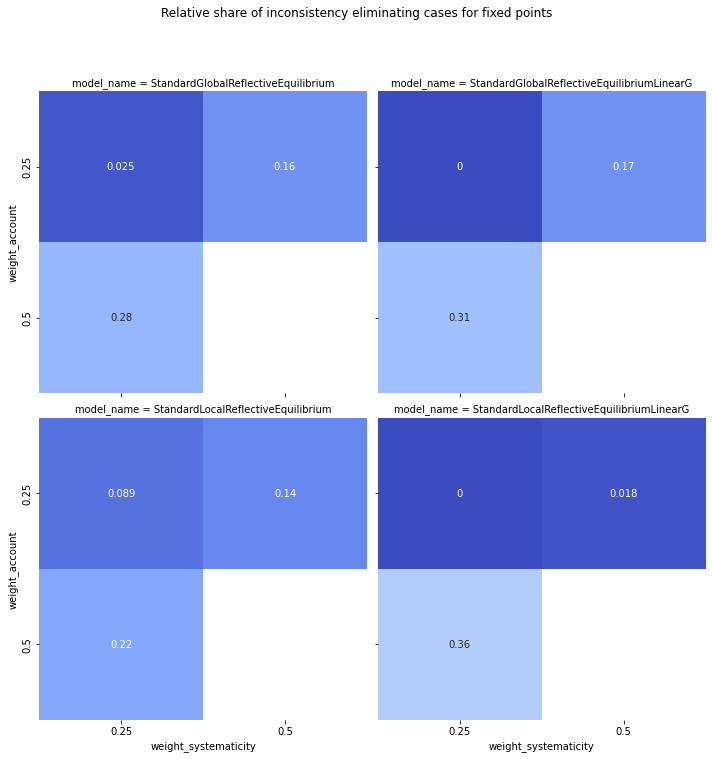

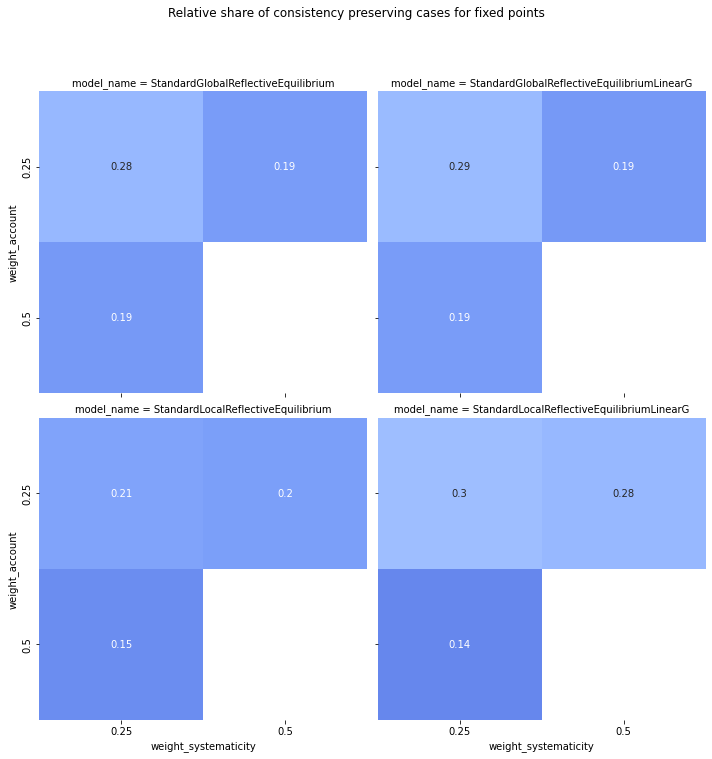

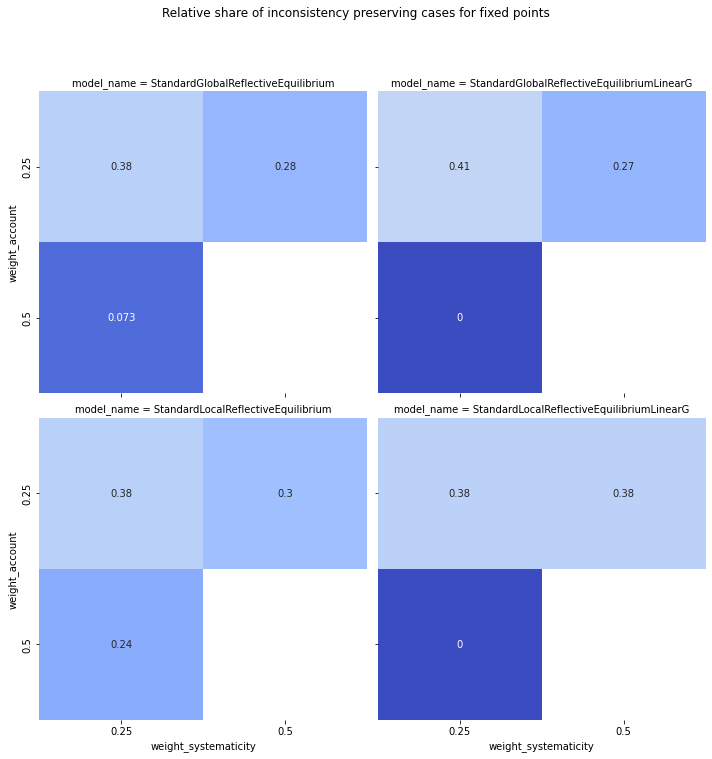

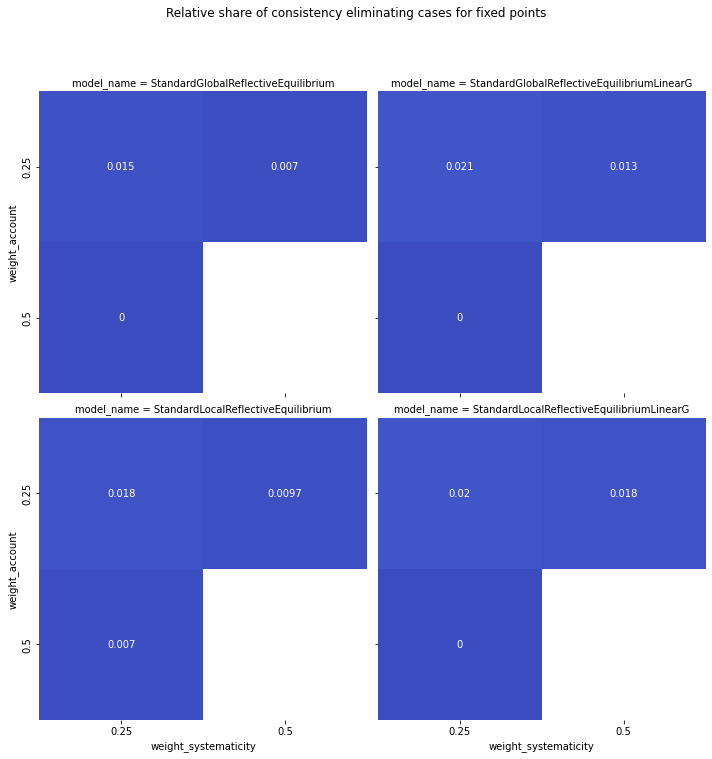

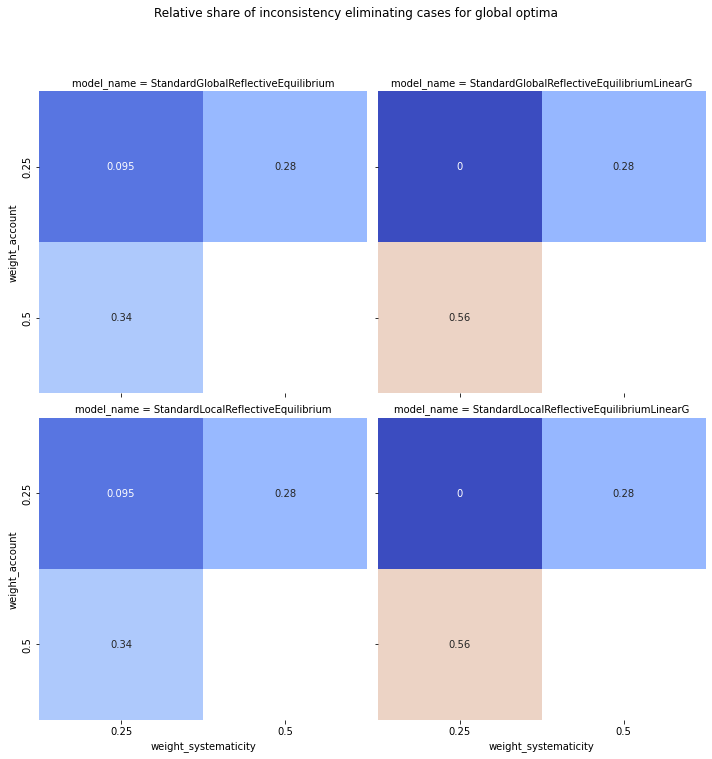

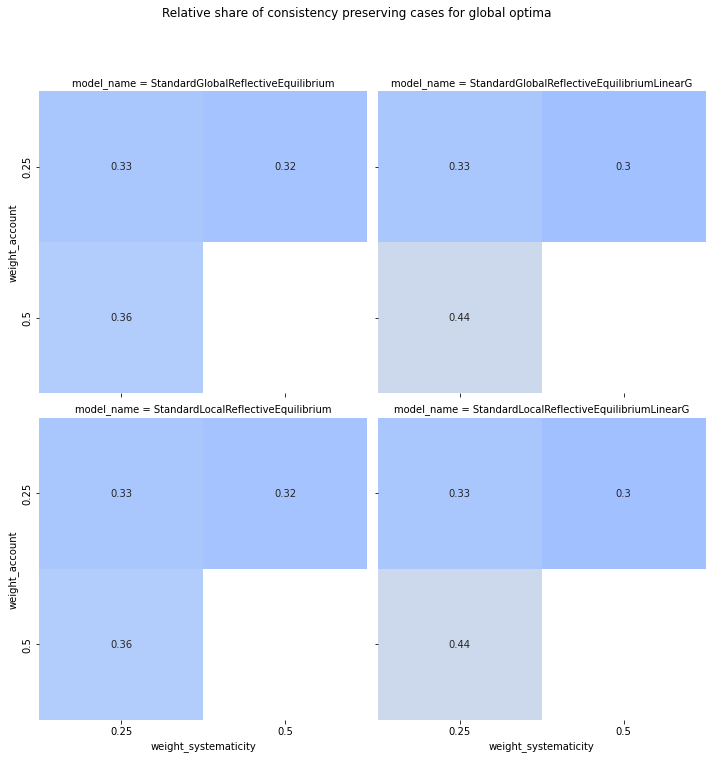

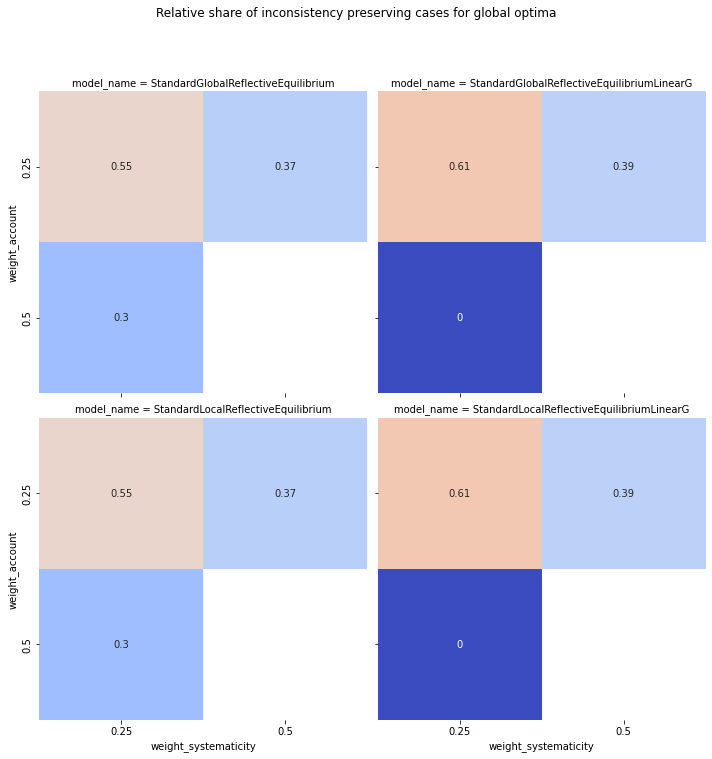

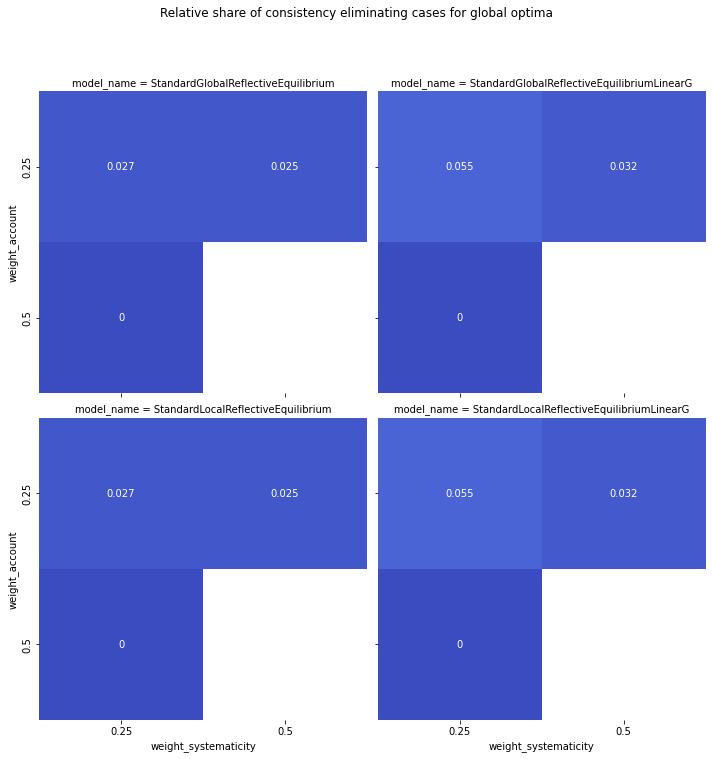

In [22]:
for df, endpoint_type in zip([fp_result_df, go_result_df], ['fp', 'go']):
    for case_name in ["inconsistency_eliminating", 
                      "consistency_preserving", 
                      "inconsistency_preserving", 
                      "consistency_eliminating"]:
        case_heatmaps_by_weights(df, endpoint_type, case_name, analyse_branches)